# FIT5196 Assessment 4
#### Student Names and Student Id : Akshay Rai Chopra(30228751) and  Parul (29507960)
#### Group Number: 154


Date: 27/10/2019

Version: 1.0

Environment: Python 3 and Jupyter notebook

#### Introduction: For this assessment, we were required to write Python (Python 3) code to integrate several datasets into one single schema and find and fix possible problems in the data.

### Libraries required


In [5]:
# !pip install shapely
# !pip install geopandas

import pandas as pd
import geopandas as gpd
import datetime
from shapely.geometry import Point
from datetime import datetime
import re

## TASK 1 - Data Integration
Integrating different datasets into one schema. We first load the data using.read_csv and then add the required columns to the dataframe.



In [6]:
data = pd.read_csv("Group154.csv")  #loading given data into a dataframe 

#adding new columns to dataframe 'data' with given default value (-1 or not available) which will ve assigned value later 
data['Suburb'] = 'not available'
data['train_station_id'] = -1
data['distance_to_train_station'] = -1
data['travel_min_to_CBD'] = -1
data['over_priced?'] = -1
data['crime_A_average'] = -1
data['crime_B_average'] = -1
data['crime_C_average'] = -1
data['closest_primary_school'] = 'not available'
data['distance_to_closest_primary'] = -1
data['primary_school_ranking'] = -1
data['closest_secondary_school'] = 'not available'
data['distance_to_closest secondary'] = -1
data['secondary_school_ranking'] = -1

### Integrating Data into Suburb

In [7]:
sub = gpd.read_file("VIC_LOCALITY_POLYGON_shp.shp") #loading suburb information into the dataframe 'sub' using geopandas

In [8]:
for a,b in data.iterrows(): #iteration on rows of dataframe 'data'
    point = Point(b['Longtitude'],b['Lattitude'])  # creating point from latitude and longitude of the house
    for x,y in sub.iterrows():     #iteration on dataframe sub to check each suburb polygon if the point(house) lies in that suburb
        polygon = y['geometry']    #polygon of each suburb
        suburb = y['VIC_LOCA_2']   #storing name of suburb for each row
        if point.within(polygon):  # check if a point is in the polygon, i.e., if house lies in that suburb 
            data.loc[a,'Suburb'] = suburb       #if yes, assign the value of suburb to the 'Suburb' column of coressponding row

### Integrating Data into train_station_id and distance_to_train_station

In [9]:
from zipfile import ZipFile

with ZipFile('gtfs/1/google_transit.zip','r') as z_obj:
    z_obj.extractall('gtfs/1/')

with ZipFile('gtfs/2/google_transit.zip','r') as z_obj:
    z_obj.extractall('gtfs/2/')

In [10]:
stop1 = pd.read_csv("gtfs/1/stops.txt", sep = ",")        #loading txt file data of regional stops into datafram 'stop1' using delimiter ','
st1 = pd.read_csv("gtfs/1/stop_times.txt", sep = ",")     #loading txt file data about trips and stops into datafram 'st1' using delimiter ','
tr1 = pd.read_csv("gtfs/1/trips.txt", sep = ",")
c1 = pd.read_csv("gtfs/1/calendar.txt", sep = ",")

stop2 = pd.read_csv("gtfs/2/stops.txt", sep = ",")        #loading txt file data of non-regional stops into datafram 'stop2' using delimiter ','
st2 = pd.read_csv("gtfs/2/stop_times.txt", sep = ",")     #loading txt file data about trips and stops into datafram 'st2' using delimiter ','
tr2 = pd.read_csv("gtfs/2/trips.txt", sep = ",")
c2 = pd.read_csv("gtfs/2/calendar.txt", sep = ",")

In [11]:
#defining a function to get the stations that has a direct trip to the Southern Cross Railway Station. 
def direct(stops,st):
    #get the station id for southern cross station
    sc_id = stops[stops['stop_name'] == 'Southern Cross Railway Station (Melbourne City)']['stop_id'].tolist()
    
    #getting trips which has a stop at southern cross station, stations on these trips has direct train to southern cross station
    t_id = st[st['stop_id'] == sc_id[0]]['trip_id'].tolist()
    
    #getting list of all stations on such trips, then converting to set to get the unique vlue or station
    s_id = set(st[st['trip_id'].isin(t_id)]['stop_id'].tolist())
    
    #returning data about the stations that are in the set above, i.e., has direct train to southern cross
    stops = stops[stops['stop_id'].isin(s_id)]
    return stops

In [12]:
#calling function for regional and non-regional stattion data to get the stations that has direct train to southern cross
#then merging two datas to get a single data frame 'stops' containing data aboout all such stations from regional/metropolitan areas

stops = direct(stop1,st1).merge(direct(stop2,st2), how="outer")

In [13]:
# import mathematical functions from math
from math import radians, sin, cos, acos
Radius_earth = 6378    #radius of the earth which is given to us is 6378


#iterrows() function will loop through each row of a dataframe as (index, series) pairs
#for loop along with iterrows will help to iterate thrrough each row one by one
for a,b in data.iterrows():
    dist_station=[] #empty list of distance for station
    lat_house = radians(b.Lattitude) #lattitude of house
    lon_house = radians(b.Longtitude)#longtitude of house

    
    for x,y in stops.iterrows():

        lat_station = radians(float(y.stop_lat)) #lattitude of the station, converted into radians 
        lon_station = radians(float(y.stop_lon)) #longtitude of the station, converted into radians
        
        #calculate the distance
        distance = Radius_earth * acos(sin(lat_house)*sin(lat_station) + cos(lat_house)*cos(lat_station)*cos(lon_house - lon_station))
        dist_station.append(distance) #append all distances from one house to each station 
            
    minimum = min(dist_station)  #minimum distance
    
    #assign the minimum distance from each house to closest station in respective col
    data.loc[a,'distance_to_train_station'] = 1000*(minimum)

    #assign the id of station in respective col
    #dist_p.index(minimum) gives the index and then locate that index in 'stops' wrt station
    data.loc[a,'train_station_id'] = str(stops.loc[dist_station.index(minimum),'stop_id'])

### Integrating Data into travel_min_to_CBD

In [14]:
#function to remove departures before 7:00 and after 9:30
def change_type(st, sc_id):
    ind = []       #blank list to store indexes of rows needs to be droped
    for x,y in st.iterrows():         #for each row 
        b = y.departure_time          #bariable b with departure time
        a = int(y.departure_time[:2]) #a with value of hour for each row
        if a>23:                      #if value of hour is greater than 23 we will drop rows, store the index value in list for dropping
            ind.append(x)
        #else, if departure i before 7:00, store index value in list for dropping
        elif (datetime.strptime(b, '%H:%M:%S') < datetime.strptime('07:00:00', '%H:%M:%S')):
            ind.append(x)
        #else, if departure i before 9:30 and station is not southern cross, store index value in list for dropping
        elif ((datetime.strptime(b, '%H:%M:%S') > datetime.strptime('09:30:00', '%H:%M:%S')) and (y.stop_id != sc_id)):
            ind.append(x)
    #drop all rows with indexes in list 
    st = st.drop(ind)
    #converting the datatype of departure_time and arrival_time columns to datetime
    st['departure_time'] = pd.to_datetime(st['departure_time'], format='%H:%M:%S')
    st['arrival_time'] = pd.to_datetime(st['arrival_time'], format='%H:%M:%S')
    
    #return the stop_times data
    return st

In [15]:
#calling function for regional and metropolitan data for removing rows with departure time not in range 7:00-9:30 and change column type
st_1 = change_type(st1,20043)
st_2 = change_type(st2,22180)

In [16]:
#function to remove trips on weekend and not direct trip to southern cross
def trip(c,tr,stop_times,stop):
    #get service id for weekdays only
    sv_id = set(c[(c['saturday'] == 0) & (c['sunday'] == 0)]['service_id'])
    #trip_id for services only on weekdays
    tr_id = set(tr[tr['service_id'].isin(sv_id)]['trip_id'])
    #getting rows only with those trip_id
    stop_times = stop_times[stop_times['trip_id'].isin(tr_id)]

    #get the station id for southern cross station
    sc_id = stop[stop['stop_name'] == 'Southern Cross Railway Station (Melbourne City)']['stop_id'].tolist()
    #getting trips which has a stop at southern cross station, stations on these trips has direct train to southern cross station
    t_id = stop_times[stop_times['stop_id'] == sc_id[0]]['trip_id'].tolist()
    #getting list of all stations on such trips, then converting to set to get the unique vlue or station
    stop_times = stop_times[stop_times['trip_id'].isin(t_id)]
    
    return stop_times

In [17]:
#calling function for both regional and metropolitan data to get details of only those that has a direct trip to the “Southern Cross Railway Station” on weekdays
st_1 = trip(c1,tr1,st_1,stop1)
st_2 = trip(c2,tr2,st_2,stop2)


In [18]:
#function to calculate the time taken for travelling to southern cross station 
def travel(stop_times,sc_id):
    #blank list to drop the rows with no train to southern cross
    drop_i = []
    #list of trip_id that has southern cross station
    t_id = stop_times[stop_times['stop_id'] == sc_id]['trip_id'].tolist()
    #arrival time to southern cross for that trip
    ar_time = stop_times[stop_times['stop_id'] == sc_id]['arrival_time'].tolist()
    #creating dictionary with keys as trip_id and values as arrival time to souther cross station
    dic_time = dict(zip(t_id, ar_time))
    for x,y in stop_times.iterrows():
        #for every row, calculating time taken to travel to southern cross station form that station for same trip id 
        if (dic_time[y.trip_id] > y.departure_time):
            stop_times.loc[x,'travelling_time'] = (dic_time[y.trip_id] - y.departure_time).seconds/60
        else:
            #if arrival time of southern cross is more than departuretime for that station drop the row
            drop_i.append(x)
    stop_times = stop_times.drop(drop_i)
    
    return stop_times

In [19]:
#calling functions for regional and metropolitan
st_1 = travel(st_1,20043)
st_2 = travel(st_2,22180)

In [20]:
#merging data for regional and metropolitan 
stop_times = st_1.merge(st_2, how = 'outer')

In [21]:
#calculating average time (minutes) from the closest train station (regional/metropolitan) that has a direct trip to the “Southern Cross Railway Station” on weekdays (i.e. Monday-Friday) departing between 7 to 9:30 am
for x,y in data.iterrows():
    #calculate average of travelling time from all values for same station to southern cross station
    avg = stop_times[stop_times['stop_id'] == int(y.train_station_id)]['travelling_time'].mean()
    #inserting values 
    data.loc[x,'travel_min_to_CBD'] = avg

### Integrating Data into over_priced?

In [22]:
data['year']=[0]*data.shape[0]      #adding a new temporary column 'year' to store the year of the property sold
for a,b in data.iterrows():         #iteration through each rowof dataframe 
    date = b['Date']                
    data.loc[a,'year']=date[-4:]    #assigning only the year from date to the 'year' column
    

In [23]:
#getting the median price of house with similar properties like no. of rooms, bathrooms, parking space, type also within the same suburb and year sold
#first we will make groups of properties with similar properties as mentioned above along with suburb and year of selling
#and for each group calculate the median of price of property
df = data.groupby(['Suburb', 'year','Rooms','Bathroom', 'Car', 'Type']).agg({'Price': ['median']})

#renaming the new column with median price value
df.columns = ['med_price']

#resetting column names , now we have a new dataframe df with set of properties and median price of property with similar set of properties
df = df.reset_index()

#merging these two dataframes (df and data) will add a new column to our main data 'data' with median price value of the similar properties 
data = data.merge(df, on=['Suburb', 'year','Rooms','Bathroom', 'Car', 'Type'], how='left')

for x,y in data.iterrows():             #iteration through each row
    if y.Price > y.med_price:           #check if the price of the property is higher than the median price of similar properties
        data.loc[x,'over_priced?'] = 1  #if yes, then insert boolean value (1) in 'over_priced?' column
    else:
        data.loc[x,'over_priced?'] = 0  #else,  insert 0

In [24]:
#droping the temporary column 'med_price' added for checking if the property is overpriced or not
data = data.drop(['med_price'],axis = 1)

### Integrating data into 
1. crime_A_average
2. crime_B_average
3. crime_C_average

As a first step we need to read the sheet of the xlsx file and we observe that it needs to be reshaped before we work on it.

In [25]:
#read sheet 'Table 1' of the  xlsx file using read_excel
crime = pd.read_excel("crimebylocationdatatable-yearending31march2016.xlsx", sheet_name='Table 1') 
crime.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Table 1. Number of offences by geographic area...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


On seeing the above dataframe we can observe some Nan Values. Steps we need to make it more readbale:
1. Dropping first 17 rows
2. Setting 18th row (1st row after dropping) as the header of the dataframe

In [26]:
crime = crime[17:] #drop first 17 rows
crime = crime.reset_index(drop=True) # reset the index
crime = crime.drop(crime.columns[0], axis=1) # drop the extra column created due to resetting

In [27]:
new_head = crime.iloc[0] # store the header of the dataframe into new_head using iloc
crime = crime[1:]        # store all rows except the first as it is a header
crime.columns = new_head # set the column names to new_head


In [28]:
#definig a blank dictionary used to store the local govt area as key and list of suburbs in it as value
dic = {}
#opening council.txt and reading each line 
with open("councils.txt") as file:
    #iteration for each line 
    for line in file:
        (key, v) = line.split(':')               #spliting line by ':' for key value pair
        
#val is a string containing names of suburbs for local govt area, we need to convert it to list of suburbs
#this is done because otherwise a check for 'BRIGHTON' will be true for 'BRIGHTON EAST' as well
        
        val = re.findall(r"'(.*?)'",v.upper())  #using regx to find all suburbs names in string val i.e, everything between quotes ('XYZ')
        dic[key.strip()] = val                  #inserting key-value pair into dictionary with local govt area as key and list of suburbs as values

In [29]:
for x,y in data.iterrows():       #iteration through each row of dataframe 'data'
    t = int(y.year)               #converting year stored in string type to integer
    for k, v in dic.items():      #checking each element (key-value pair) of dictionary created abpve
        if y.Suburb in v:         #if the suburb is the the value i.e., the list of suburbs
            area = k              #then store the key (local govt area for that suburb) in variable 'area'
    
    
    a_avg = crime[((crime['Apr - Mar reference period'] == t-1) | (crime['Apr - Mar reference period']== t-2) | (crime['Apr - Mar reference period']== t-3)) &  (crime['CSA Offence Division'] == 'A Crimes against the person') & (crime['Local Government Area'] == area)].loc[:,"Offence Count"].mean()
    b_avg = crime[((crime['Apr - Mar reference period'] == t-1) | (crime['Apr - Mar reference period']== t-2) | (crime['Apr - Mar reference period']== t-3)) &  (crime['CSA Offence Division'] == 'B Property and deception offences') & (crime['Local Government Area'] == area)].loc[:,"Offence Count"].mean()
    c_avg = crime[((crime['Apr - Mar reference period'] == t-1) | (crime['Apr - Mar reference period']== t-2) | (crime['Apr - Mar reference period']== t-3)) &  (crime['CSA Offence Division'] == 'C Drug offences') & (crime['Local Government Area'] == area)].loc[:,"Offence Count"].mean()
    
    #inserting the calculated average number of crimes of each type A,B,C to coressponding columns for each row
    data.loc[x,'crime_A_average'] = a_avg
    data.loc[x,'crime_B_average'] = b_avg
    data.loc[x,'crime_C_average'] = c_avg

### Integrating data into
1. closest_primary_school and distance_to_closest_primary
2. closest_secondary_school and distance_to_closest secondary

Parsing the xml file and converting that data to the pandas dataframe

In [30]:
import xml.etree.ElementTree as ET  # ElementTree breaks the xml document into a tree structure which is easy to work with
tree = ET.parse('schools.xml')      # parse or extract the xml file and store in tree
root = tree.getroot()               # Every part of a tree (root included) has a tag that describes the element

df_columns = ["school", "Type", "Longitude", "Lattitude"] #create a list of columns we want in the new datframe
df_school = pd.DataFrame(columns = df_columns)            # create a dataframe using pd.DataFrame with the col created.

for x in root:                                # for loop to extract all the data
    school = x.attrib.get("School")           # extract name,type, longitude and Latitude of the school from the attribute "School"
    school_name = x.find("School_Name").text  # find() finds the first child with a particular tag
    Type = x.find("School_Type").text         #.text to convert the finding into text
    lon = x.find("X").text
    lat = x.find("Y").text
    
    df_school = df_school.append(pd.Series([school_name, Type, lon , lat ], index = df_columns), ignore_index = True)
    # append each row as series one by one in the dataframe.
df_school.head(5)

,school,Type,Longitude,Lattitude
0,Alberton Primary School,Primary,146.666601,-38.617713
1,Allansford and District Primary School,Primary,142.590393,-38.386281
2,Avoca Primary School,Primary,143.475649,-37.084502
3,Avenel Primary School,Primary,145.234722,-36.901368
4,Warrandyte Primary School,Primary,145.21398,-37.742675


In [31]:
#create 2 dataframes, each for primary and secondary
#filter df_school on the basis of its type
# Primary or Pri/Sec for df_primary
# Secondary or Pri/Sec for df_secondary

df_primary = df_school[ (df_school["Type"]== 'Primary') | (df_school["Type"]=='Pri/Sec')]
df_secondary = df_school [(df_school["Type"]== 'Secondary') | (df_school["Type"]=='Pri/Sec')]

#reset the index of both the dataframes.
df_primary = df_primary.reset_index(drop=True)
df_secondary = df_secondary.reset_index(drop=True)

Finding the shortest distance between the house and school. The formula used for calculating:
    $$ Distance = Radius * acos(sin(lat_1) * sin (lat_2)  + cos(lat_1) * cos(lat_2) * cos(lon_1 - lon_2))$$

source - https://www.w3resource.com/python-exercises/math/python-math-exercise-27.php

In [32]:
# import mathematical functions from math
from math import radians, sin, cos, acos
Radius_earth = 6378    #radius of the earth which is given to us is 6378


#iterrows() function will loop through each row of a dataframe as (index, series) pairs
#for loop along with iterrows will help to iterate thrrough each row one by one
for a,b in data.iterrows():
    dist_p=[] #empty list of distance for primary school
    dist_s=[] #empty list of distance for secondary school
    lat_house = radians(b.Lattitude) #lattitude of house
    lon_house = radians(b.Longtitude)#longtitude of house

    
    for x,y in df_primary.iterrows():

        lat_school = radians(float(y.Lattitude)) #lattitude of the school, converted into radians 
        lon_school = radians(float(y.Longitude)) #longtitude of the school, converted into radians
        
        #calculate the distance
        distance = Radius_earth * acos(sin(lat_house)*sin(lat_school) + cos(lat_house)*cos(lat_school)*cos(lon_house - lon_school))
        dist_p.append(distance) #append all distances from one house to each primary school 
            
    minimum = min(dist_p)  #minimum distance
    
    #assign the minimum distance from each house to closest primary school in respective col
    data.loc[a,'distance_to_closest_primary'] = 1000*(minimum)
    
    #assign the name of the school in respective col
    #dist_p.index(minimum) gives the index and then locate that index in df_primary wrt school
    data.loc[a,'closest_primary_school'] = df_primary.loc[dist_p.index(minimum),'school'] 
    
    
    for x,y in df_secondary.iterrows():

        lat_school = radians(float(y.Lattitude))  #lattitude of the school, converted into radians
        lon_school = radians(float(y.Longitude))  #longtitude of the school, converted into radians

        #calculate the distance
        distance = Radius_earth * acos(sin(lat_house)*sin(lat_school) + cos(lat_house)*cos(lat_school)*cos(lon_house - lon_school))
        dist_s.append(distance) #append all distances from one house to each secondary school
            
    minimum = min(dist_s) #minimum distance
    
    #assign the minimum distance from each house to closest secondary school in respective col
    data.loc[a,'distance_to_closest secondary'] = 1000*(minimum) 
    
    #assign the name of the school in respective col
    #dist_s.index(minimum) gives the index and then locate that index in df_secondary wrt school
    data.loc[a,'closest_secondary_school'] = df_secondary.loc[dist_s.index(minimum),'school']

### Integrating data into
1. primary_school_ranking 
2. secondary_school_ranking

The rankings for primary school has been given in the following link: http://www.schoolcatchment.com.au/?p=12301. Scrapped the data from the link with the help of BeautifulSoup

The rankings for secondary school has been given in the following link: https://sites.google.com/a/monash.edu/secondary-school-ranking/. We downloaded the data as html file in our machine and then read it using codecs. Then scrapping the data with the help of BeeautifulSoup.

In [33]:
##PRIMARY SCHOOL

#import the required packages
from urllib.request import urlopen 
from bs4 import BeautifulSoup

#Firstly, use the urlopen() function to open the web page for "the rankings of primary school",
#parse the HTML with the help of BeautifulSoup
html = urlopen("http://www.schoolcatchment.com.au/?p=12301")
bsobj = BeautifulSoup(html, "lxml")

We will create a dictionary of the rankings for primary schools after extracting the info from the link.

In [34]:
rank = bsobj.find_all(class_=['column-1'])    #finding the ranking of the schools from the table in webpage, class is column-1
ranking=[]                                    #create an empty list
for tag in rank:                              #extract the textual content of each tag using for loop and append it into 'ranking'
    ranking.append(tag.text)

p_school = bsobj.find_all(class_=['column-2']) #finding the name of the schools from the table in webpage, class is column-2
p_name = []                             #create an empty list
for tag in p_school:                    #extract the textual content of each tag using for loop and append it into 'p_name'
    p_name.append(tag.text)

# We create a dataframe with two colummns: school_name and Rank
dd = {'school_name':p_name,'Rank':ranking} 
dff = pd.DataFrame(dd)

dff=dff.drop(0,axis = 0) #drop the first row as it is of no use
dff[dff['school_name']=="St Joseph's School"] #same school with multiple ranks

,school_name,Rank
113,St Joseph's School,113
307,St Joseph's School,307
334,St Joseph's School,334
375,St Joseph's School,375
400,St Joseph's School,400
401,St Joseph's School,401
477,St Joseph's School,477


Therefore we consider the rows which have lower rank. We use .drop_duplicates() to acheive the result.

In [35]:
dff=dff.drop_duplicates(subset="school_name", keep ='first') #drop the duplicate rows and keep the first rank (lower rank)
p_dic = dict(zip(dff.school_name, dff.Rank)) #create the dictionary p_dic with college_name as key and ranking as value
p_dic

{"Presbyterian Ladies' College": '1',
 'Haileybury College': '2',
 'Ballarat Clarendon College': '3',
 'Fitzroy Community School': '4',
 "Fintona Girls' School": '5',
 'Huntingtower School': '6',
 'Beverley Hills Primary School': '7',
 'Oakleigh South Primary School': '8',
 'Scotch College': '9',
 'Serpell Primary School': '10',
 'Camberwell Grammar School': '11',
 "Mentone Girls' Grammar School": '12',
 'St Andrews Christian College': '13',
 'Christ Church Grammar School': '14',
 'Waverley Christian College': '15',
 'Balwyn Primary School': '16',
 'Erasmus School': '17',
 'Lighthouse Christian College Cranbourne': '18',
 'Glendal Primary School': '19',
 'Thomastown East Primary School': '20',
 'Doncaster Gardens Primary School': '21',
 "Korowa Anglican Girls' School": '22',
 'Carey Baptist Grammar School': '23',
 'Firbank Grammar School': '24',
 'The Knox School': '25',
 'Southmoor Primary School': '26',
 'Loreto Mandeville Hall': '27',
 'Wheelers Hill Primary School': '28',
 'Camberw

In [36]:
## SECONDARY SCHOOL

#import codec to open the HTML file into python 
import codecs 
file = codecs.open("secondary-school-ranking.html", 'r','utf-8')   #open the file 
bsobj_2 = BeautifulSoup(file, "lxml")                              #parse the HTML with the help of BeautifulSoup


We will create a dictionary of the rankings for secondary schools after extracting the info from the html file.

In [37]:
sec=bsobj_2.find_all('li')                 # find all the 'li' tags
sec_school=[]                              # empty list
for tag in sec:                            # extract the textual content of each tag using for loop and then remove the trailing and leading space
    sec_school.append(tag.text.strip())
    
sec_school = sec_school[8:] # keeping the required textual content 

#extracting the rankings and school_name in respective lists
s_name=[]
rank_s=[]
for x in sec_school:
    a = x.split('\n')  #split the element of the above list
    s_name.append(a[0])
    rank_s.append(a[1])
    
# We create a dataframe with two colummns: school_name and Rank
gg =  {'school_name':s_name,'Rank':rank_s}
dgg = pd.DataFrame(gg)

dgg[dgg['school_name']=="Catholic Regional College"] #same school with multiple ranks

,school_name,Rank
92,Catholic Regional College,236
93,Catholic Regional College,271
94,Catholic Regional College,541
95,Catholic Regional College,542
96,Catholic Regional College,543


Therefore we consider the rows which have lower rank. We use .drop_duplicates() to acheive the result.

In [38]:
dgg=dgg.drop_duplicates(subset="school_name", keep ='first') #drop the duplicate rows and keep the first rank (lower rank)

s_dic = dict(zip(dgg.school_name, dgg.Rank)) ##create the dictionary p_dic with college_name as key and ranking as value
s_dic

{'Academy of Mary Immaculate': '144',
 'Adass Israel School': '534',
 'Advance College of Education': '535',
 'Aitken College': '194',
 'Al Siraat College': '280',
 'Al-Taqwa College': '400',
 'Albert Park College': '131',
 'Albury Wodonga Comm College': '536',
 'Alexandra Secondary College': '481',
 'Alia College': '500',
 'Alice Miller School': '127',
 'Alkira Secondary College': '328',
 'Alphington Grammar School': '86',
 'Antonine College': '482',
 'Apollo Bay P-12 College': '18',
 'Aquinas College': '151',
 'Ararat Secondary College': '486',
 'Ashwood High School': '241',
 'Assumption College': '301',
 'Auburn High School': '167',
 'Australian Internatl Academy': '501',
 'Ave Maria College': '111',
 'Avila College': '102',
 'Bacchus Marsh College': '496',
 'Bacchus Marsh Grammar': '147',
 'Baimbridge College': '452',
 'Bairnsdale Secondary College': '513',
 'Balcombe Grammar School': '156',
 'Ballarat Christian College': '408',
 'Ballarat Clarendon College': '12',
 'Ballarat Gramm

* p_dic is the dictionary with all primary schools as key and their ranks
* s_dic is the dictionary with all secondary schools as key and their ranks

NOTE - Another problem occured

In [39]:
p_dic['Aitken College']

'432'

In [40]:
s_dic['Aitken College']

'194'

Aitken College is 1 of the 71 colleges which is listed in both of the dictionaries and their ranking is different in both the dicts. So we now need to merge the two dictionaries such that the new dictionary has the minimum value for the common keys.

In [41]:
# create a function to merge the 2 dictionaries created above
# merge with **kwarg will de-serialize the contents of dictionary to a collection of key/value pairs
# **dict1 & **dict2 expanded the contents of both the dictionaries to a collection of key value pairs
# Therefore, a new dictionary is created that contains the data from both the dictionaries.
# But we want to keep the college with lower rank, so after merging, we create a dict
# in way that it should keep the minimum value for common keys in a list

def merge_dic(dict1, dict2):
    dict3 = {**dict1, **dict2}
    for key, value in dict3.items():
        if key in dict1 and key in dict2:
            dict3[key] = min([value , dict1[key]])
    return dict3
 
# call the function to merge dictionaries
final_dic = merge_dic(p_dic, s_dic)
final_dic

{"Presbyterian Ladies' College": '1',
 'Haileybury College': '2',
 'Ballarat Clarendon College': '12',
 'Fitzroy Community School': '4',
 "Fintona Girls' School": '5',
 'Huntingtower School': '3',
 'Beverley Hills Primary School': '7',
 'Oakleigh South Primary School': '8',
 'Scotch College': '31',
 'Serpell Primary School': '10',
 'Camberwell Grammar School': '11',
 "Mentone Girls' Grammar School": '12',
 'St Andrews Christian College': '13',
 'Christ Church Grammar School': '14',
 'Waverley Christian College': '15',
 'Balwyn Primary School': '16',
 'Erasmus School': '17',
 'Lighthouse Christian College Cranbourne': '18',
 'Glendal Primary School': '19',
 'Thomastown East Primary School': '20',
 'Doncaster Gardens Primary School': '21',
 "Korowa Anglican Girls' School": '13',
 'Carey Baptist Grammar School': '23',
 'Firbank Grammar School': '24',
 'The Knox School': '110',
 'Southmoor Primary School': '26',
 'Loreto Mandeville Hall': '15',
 'Wheelers Hill Primary School': '28',
 'Camb

In [42]:
#it worked
final_dic['Aitken College']

'194'

We now have all primary and secondary schools with their rankings in the final dic. Now assigning the rankings into the respected column w.r.t the school names. If school is in not present in the dictionary we assign 'not ranked' in the rankings column.

In [43]:
#iterrows() function will loop through each row of a dataframe as (index, series) pairs
#for loop along with iterrows will help to iterate thrrough each row one by one.
for i,j in data.iterrows():
    pr = j.closest_primary_school           #primary school
    sc = j.closest_secondary_school         #secondary school
    
    
    #if primary school is in the keys of dic, then assign its ranking into the column
    if pr in final_dic.keys():
        data.loc[i,'primary_school_ranking'] = final_dic[pr]
    else:
        data.loc[i,'primary_school_ranking'] = 'not ranked'
    
    #if secondary school is in the keys of dic, then assign its ranking into the column
    if sc in final_dic.keys():
        data.loc[i,'secondary_school_ranking'] = final_dic[sc]
    else:
        data.loc[i,'secondary_school_ranking'] = 'not ranked'

In [56]:
data=data.rename(columns = {'Lattitude':'Latitude'})
data=data.rename(columns = {'Longtitude':'Longitude'})
data=data.rename(columns = {'Landsize':'LandSize'})
data = data.drop('year',axis = 1)
data = data[['ID','Address','Suburb','Price','Type','Date','Rooms','Bathroom','Car','LandSize','Age','Latitude','Longitude','train_station_id','distance_to_train_station','travel_min_to_CBD','over_priced?','crime_A_average','crime_B_average','crime_C_average','closest_primary_school','distance_to_closest_primary','primary_school_ranking','closest_secondary_school','distance_to_closest secondary','secondary_school_ranking']]
data.to_csv("Group154_solution.csv")

In [57]:
data.head(3)

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,LandSize,...,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest secondary,secondary_school_ranking
0,ID353607679,3 Surf St,PARKDALE,1415000.0,h,27/05/2017,3,1.0,2.0,545.0,...,0,117.291667,1378.533333,150.909091,Parkdale Primary School,938.218169,128,St Bede's College,988.686485,171
1,ID799591218,22 Milliara Gr,BRIGHTON EAST,1880000.0,h,13/05/2017,8,3.0,3.0,614.0,...,0,362.166667,2108.062500,314.000000,Gardenvale Primary School,566.710740,138,Brighton Secondary College,1193.746660,213
2,ID509406085,29 Beaver St,ABERFELDIE,1740000.0,h,18/06/2016,5,3.0,2.0,839.0,...,0,100.523810,300.400000,45.222222,Resurrection House,417.488599,329,Ave Maria College,408.841662,111


## Task 2 - Data Reshaping

In order to build the linear model, we need to observe and study the effect of the parameters on the desired result. In doing so, normalization/transforrmation can be applied in order to achieve better results.

###  Data Transformation:
There are 3 kinds of transformation:
* log transformation
* power transformation
* root transfoirmation.

We applied all 3 transformations to all 4 attributes(Age, Rooms, crime_C_average, travel_min_to_CBD) and visualize it by plotting the scatter plots of each transformation on each attribute with price. 



In [59]:
df1 = data[['Rooms', 'Age','crime_C_average','travel_min_to_CBD','Price' ]] 
#slicing the datframe and saving it new datframe
#root transformation
import math
df1['root_room'] = None
df1['root_age'] = None
df1['root_crime'] = None
df1['root_price'] = None

i = 0
for row in data.iterrows():
    df1['root_room'].at[i] = math.sqrt(df1["Rooms"][i])
    df1['root_age'].at[i] = math.sqrt(df1["Age"][i])
    df1['root_crime'].at[i] = math.sqrt(df1["crime_C_average"][i])
    df1['root_price'].at[i] = math.sqrt(df1["Price"][i])
    
    i += 1
    
#power_transformation
df1['sq_room'] = None
df1['sq_age'] = None
df1['sq_crime'] = None
df1['sq_price'] = None
i = 0
for row in data.iterrows():
    df1['sq_room'].at[i] = math.pow(df1["Rooms"][i],2)
    df1['sq_age'].at[i] = math.pow(df1["Age"][i],2)
    df1['sq_crime'].at[i] = math.pow(df1["crime_C_average"][i],2)
    df1['sq_price'].at[i] = math.pow(df1["Price"][i],2)
    
    i += 1
    
#log_transformation
df1['log_room'] = None
df1['log_age'] = None
df1['log_crime'] = None
df1['log_price'] = None
i = 0
for row in data.iterrows():
    df1['log_room'].at[i] = math.log(df1["Rooms"][i])
    df1['log_age'].at[i] = math.log(df1["Age"][i])
    df1['log_crime'].at[i] = math.log(df1["crime_C_average"][i])
    df1['log_price'].at[i] = math.log(df1["Price"][i])
    
    i += 1

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-vie

The dataframe has been transformed and now we need to visualize the effect of transformation, so using matplotlib.pyplot.subplots we plotted 9 scatter plots. Each plot has different transformed attribute on x axis v/s transformed price on yaxis. travel_min_to_CBD will be transformed in the next cell.

In [62]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'log_crime vs log_price')

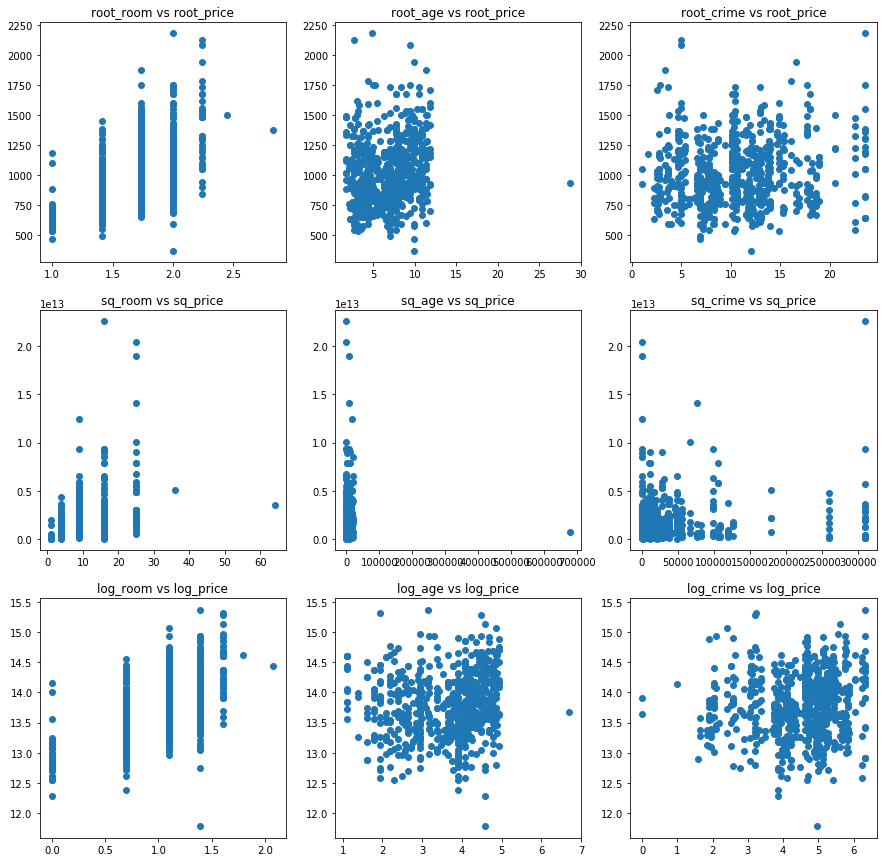

In [63]:

fig, axs = plt.subplots(3,3)
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0, 0].scatter(df1.root_room, df1.root_price)
axs[0, 0].set_title('root_room vs root_price')

axs[0, 1].scatter(df1.root_age, df1.root_price)
axs[0, 1].set_title('root_age vs root_price')

axs[0, 2].scatter(df1.root_crime, df1.root_price)
axs[0, 2].set_title('root_crime vs root_price')

axs[1, 0].scatter(df1.sq_room, df1.sq_price)
axs[1, 0].set_title('sq_room vs sq_price')

axs[1, 1].scatter(df1.sq_age, df1.sq_price)
axs[1, 1].set_title('sq_age vs sq_price')

axs[1, 2].scatter(df1.sq_crime, df1.sq_price)
axs[1, 2].set_title('sq_crime vs sq_price')

axs[2, 0].scatter(df1.log_room, df1.log_price)
axs[2, 0].set_title('log_room vs log_price')

axs[2, 1].scatter(df1.log_age, df1.log_price)
axs[2, 1].set_title('log_age vs log_price')

axs[2, 2].scatter(df1.log_crime, df1.log_price)
axs[2, 2].set_title('log_crime vs log_price')

None of the plots are giving spreads, good enough to claim that they are good predictor. So now we try the effect of transformation on travel_min_to_CBD and then see its effect

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

Text(0.5, 1.0, 'log_time vs root_price')

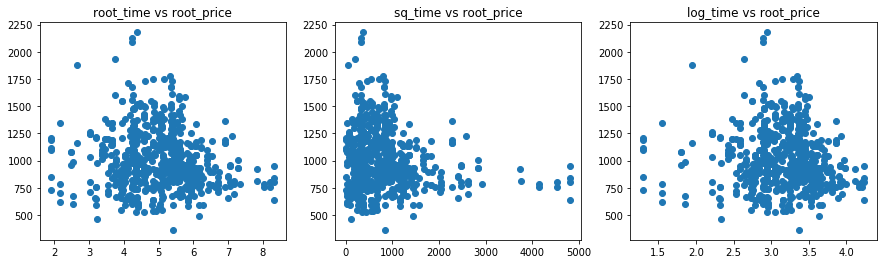

In [61]:
# applying each transformation on travel_min_to_CBD
df1['root_time'] = None
df1['sq_time'] = None
df1['log_time']= None

i = 0
for row in data.iterrows():
    df1['root_time'].at[i] = math.sqrt(df1["travel_min_to_CBD"][i])
    df1['sq_time'].at[i] = math.pow(df1["travel_min_to_CBD"][i],2)
    df1['log_time'].at[i] = math.log(df1["travel_min_to_CBD"][i])
    
    i=i+1
    
# After transforming the data, we plot it and visualize the scatter plot.

fig, axs = plt.subplots(1,3)
fig.set_figheight(4)
fig.set_figwidth(15)
axs[0].scatter(df1.root_time, df1.root_price)
axs[0].set_title('root_time vs root_price')

axs[1].scatter(df1.sq_time, df1.root_price)
axs[1].set_title('sq_time vs root_price')

axs[2].scatter(df1.log_time, df1.root_price)
axs[2].set_title('log_time vs root_price')

The spread seems fine and we can have a bit idea that price has something to do with travel_min_to_CBD. We check the effect using Z-score Normalisation
We use scikit-learn linrary for standardise data (mean=0, SD=1). The class we used is StandardScaler class


In [64]:
from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(df1[['travel_min_to_CBD', 'Price']])
df_std = std_scale.transform(df1[['travel_min_to_CBD', 'Price']]) # an array not a df
df_std[0:5]



array([[ 1.98665163,  0.49827529],
       [-0.18500274,  1.26080774],
       [-0.74283784,  1.03122808],
       [-2.0106449 ,  1.13453892],
       [-0.46096878, -0.62502519]])

In [65]:
# put it alongside data... to view
df1['time_scaled'] = df_std[:,0] # so 'time' is  time_scaled
df1['price_scaled'] = df_std[:,1] # and 'price' is price_scaled
df1.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Rooms,Age,crime_C_average,travel_min_to_CBD,Price,root_room,root_age,root_crime,root_price,sq_room,...,sq_price,log_room,log_age,log_crime,log_price,root_time,sq_time,log_time,time_scaled,price_scaled
0,3,69.0,150.909091,47.691358,1415000.0,1.73205,8.30662,12.2845,1189.54,9,...,2.00222e+12,1.09861,4.23411,5.01668,14.1626,6.90589,2274.47,3.86475,1.986652,0.498275
1,8,94.0,314.000000,24.333333,1880000.0,2.82843,9.69536,17.72,1371.13,64,...,3.5344e+12,2.07944,4.54329,5.74939,14.4468,4.93288,592.111,3.19185,-0.185003,1.260808
2,5,94.0,45.222222,18.333333,1740000.0,2.23607,9.69536,6.72475,1319.09,25,...,3.0276e+12,1.60944,4.54329,3.81159,14.3694,4.28174,336.111,2.90872,-0.742838,1.031228
3,2,59.0,7.666667,4.696970,1803000.0,1.41421,7.68115,2.76887,1342.76,4,...,3.25081e+12,0.693147,4.07754,2.03688,14.405,2.16725,22.0615,1.54692,-2.010645,1.134539
4,3,49.0,51.000000,21.365079,730000.0,1.73205,7,7.14143,854.4,9,...,5.329e+11,1.09861,3.89182,3.93183,13.5008,4.62224,456.467,3.06176,-0.460969,-0.625025


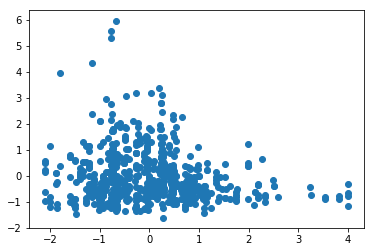

In [66]:
plt.scatter(df1["time_scaled"], df1["price_scaled"]) #we plot the scatter plot

The spread is good and we can state that <b>travel_min_to_CBD</b> is a good predictor for price. As the travelling time from property to southern cross station decreases, the prices for house starts to increase. Travelling time being less means , that the property from the nearest station to southern cross station is located closer to the CBD. Which means if the hosue is located in CBD, the prices are going to be comapritvely high for the similar type of property. 